In [ ]:
!pip install transformers[torch]==4.19.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 91.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from time import gmtime, strftime
from sklearn import metrics
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, precision_score
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW
from tqdm import tqdm, trange
import torch
import torch.nn as nn
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from time import time
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import pickle
plt.rcParams["figure.dpi"] = 200

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device available: ",device)
seed = 42
np.random.seed(seed)

Device available:  cpu


In [ ]:
## Input
# Trained Model
distilbert_model_path = '/content/drive/MyDrive/NLP_LSS/distinctiveness_indicator/distilbert/model/distilbert_unprocessed_v1.pth'
# Input Data
data_path = '/content/drive/MyDrive/NLP_LSS/distinctiveness_indicator/distilbert/data/df_distilbert_input_unprocessed.pkl'
# DistilBERT Tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-cased')
# Temperature for final model
TEMP = 0.75

## Output
curr_time = strftime("%Y-%m-%d %H:%M:%S", gmtime())

acc_list_path = '/content/drive/MyDrive/NLP_LSS/distinctiveness_indicator/distilbert/bootstrap/base-model/accuracy_list_' + curr_time + '.pickle'
auc_list_path = '/content/drive/MyDrive/NLP_LSS/distinctiveness_indicator/distilbert/bootstrap/base-model/auc_list_' + curr_time + '.pickle'
prec_list_path = '/content/drive/MyDrive/NLP_LSS/distinctiveness_indicator/distilbert/bootstrap/base-model/prec_list_' + curr_time + '.pickle'
recall_list_path = '/content/drive/MyDrive/NLP_LSS/distinctiveness_indicator/distilbert/bootstrap/base-model/recall_list_' + curr_time + '.pickle'
f1_list_path = '/content/drive/MyDrive/NLP_LSS/distinctiveness_indicator/distilbert/bootstrap/base-model/f1_list_' + curr_time + '.pickle'
results_path = '/content/drive/MyDrive/NLP_LSS/distinctiveness_indicator/distilbert/bootstrap/base-model/df_bootstrap_results.csv'
summary_stats_path = '/content/drive/MyDrive/NLP_LSS/distinctiveness_indicator/distilbert/bootstrap/base-model/summary_stats.csv'


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/465 [00:00<?, ?B/s]

In [ ]:
# Function to generate batches and reshape
def batching(np_array, max_idx, batch_size):
    np_array = np_array[:max_idx]
    np_array = np_array.reshape(-1, batch_size)
    batched_list = np_array.tolist()
    return batched_list

In [ ]:
# Temperature Scaling
def T_scaling(logits, args):
    temperature = args.get('temperature', None)
    return torch.div(logits, temperature)

In [ ]:
# Function for predicting y
def bert_pred(loaded_model, X, y, th=0.5, temp=TEMP):
    predictions, targets = [], []
    pred_prob = []
    loaded_model.eval()
    with torch.no_grad():
        for text, labels in tqdm(zip(X, y), total=len(X)):
            #try:
            model_inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
            model_inputs = {k:v.to(device) for k,v in model_inputs.items()}
            output = loaded_model(**model_inputs)
            logits = output[0]
            if temp is not None:
                logits = T_scaling(logits, {'temperature':temp})
            probs = torch.sigmoid(logits)
            pred_prob.extend(probs[:,1].tolist())
            if th==0.5:
                # prediction is the argmax of the logits
                predictions.extend(logits.argmax(dim=1).tolist())
            else:
                predictions.extend(((probs[:,1]>=th)*1).tolist())
            targets.extend(labels)
            #except:
            #    print("Unable to process: ", text)
            #    continue
    return targets, pred_prob, predictions

In [ ]:
# Function to evaluate predictions - classification report
def classification_metrics(targets, predictions, pred_prob):
    accuracy = metrics.accuracy_score(targets, predictions)
    auc_score = roc_auc_score(targets, pred_prob)
    cls_report = metrics.classification_report(targets, predictions, output_dict=True)
    precision = cls_report['weighted avg']['precision']
    recall = cls_report['weighted avg']['recall']
    f1 = cls_report['weighted avg']['f1-score']
    return accuracy, auc_score, precision, recall, f1

In [ ]:
# Function to evaluate AUC ROC scores
def auc_roc(y_true, y_score):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    auc = roc_auc_score(y_true, y_score)
    return auc, fpr, tpr

In [ ]:
def get_Xy(df, x_col='bert_input_unprocessed', y_col='distinct_ind'):
  # X_test
  X_test = np.array(df[x_col])
  # y_test
  y_test = np.array(df[y_col])

  batch_size = 16
  # Batching
  test_max_idx = batch_size * (len(X_test)//batch_size)
  X_test = batching(X_test, test_max_idx, batch_size=16)
  y_test = batching(y_test, test_max_idx, batch_size=16)

  return X_test, y_test

In [ ]:
def bootstrap(nrounds, data_path=data_path, model_path=distilbert_model_path):
  # Read data
  df = pd.read_pickle(data_path)
  df['filing_dt'] = pd.to_datetime(df['filing_dt'])

  # Divide data into train, test and validation
  df_train = df[(df['filing_dt']>=pd.to_datetime('2012-01-01')) & (df['filing_dt']<=pd.to_datetime('2017-12-31'))]
  df_val = df[(df['filing_dt']>=pd.to_datetime('2018-01-01')) & (df['filing_dt']<=pd.to_datetime('2018-12-31'))]
  df_test = df[(df['filing_dt']>=pd.to_datetime('2019-01-01')) & (df['filing_dt']<=pd.to_datetime('2019-12-31'))]
  print("Train data shape: ", df_train.shape)
  print("Validation data shape: ", df_val.shape)
  print("Test data shape: ", df_test.shape)

  acc_list = []
  auc_list = []
  prec_list = []
  recall_list = []
  f1_list = []
  model = torch.load(model_path)

  for i in range(nrounds):
    torch.cuda.empty_cache()
    # Sample with replacements
    df_test = df_test.sample(frac=1, replace=True)
    X_test, y_test = get_Xy(df_test)
    labels, pred_prob, predictions = bert_pred(model, X_test, y_test)
    acc, auc, prec, recall, f1 = classification_metrics(labels, predictions, pred_prob)
    print("Round {round}: accuracy {accr}".format(round=i+1, accr=acc))
    acc_list.append(acc)
    auc_list.append(auc)
    prec_list.append(prec)
    recall_list.append(recall)
    f1_list.append(f1)

  return acc_list, auc_list, prec_list, recall_list, f1_list

In [ ]:
acc_list, auc_list, prec_list, recall_list, f1_list = bootstrap(nrounds=6)

# Dump
with open(acc_list_path, 'wb') as handle:
  pickle.dump(acc_list, handle)

with open(auc_list_path, 'wb') as handle:
  pickle.dump(auc_list, handle)

with open(prec_list_path, 'wb') as handle:
  pickle.dump(prec_list, handle)

with open(recall_list_path, 'wb') as handle:
  pickle.dump(recall_list, handle)

with open(f1_list_path, 'wb') as handle:
  pickle.dump(f1_list, handle)

Train data shape:  (1001779, 22)
Validation data shape:  (234752, 22)
Test data shape:  (264827, 22)


100%|██████████| 16551/16551 [19:14<00:00, 14.34it/s]


Round 1: accuracy 0.8563568666545828


100%|██████████| 16551/16551 [19:00<00:00, 14.51it/s]


Round 2: accuracy 0.856689172859646


100%|██████████| 16551/16551 [19:00<00:00, 14.51it/s]


Round 3: accuracy 0.8558433025194853


100%|██████████| 16551/16551 [19:01<00:00, 14.50it/s]


Round 4: accuracy 0.8550616276962117


100%|██████████| 16551/16551 [19:09<00:00, 14.40it/s]


Round 5: accuracy 0.8552504380399976


100%|██████████| 16551/16551 [19:11<00:00, 14.37it/s]


Round 6: accuracy 0.8554656818319135


In [ ]:
# from google.colab import runtime
# runtime.unassign()

### Load all accuracies, precision, recall, F1 and AUC to create a violin plot  

In [ ]:
import os
import matplotlib.pyplot as plt
import pickle
import pandas as pd
plt.rcParams["figure.dpi"] = 80

In [ ]:
## Input paths
data_path = '/content/drive/MyDrive/NLP_LSS/distinctiveness_indicator/distilbert/bootstrap/base-model/'

def get_paths(str_match, folder_path=data_path):
  path_list = []
  for root, dirs, files in os.walk(folder_path):
    for file in files:
      if str_match in file:
        path_list.append((os.path.join(root, file)))
  return path_list

def concat_data(paths, n=30):
  all_data = []
  for path in paths:
    with open(path, 'rb') as handle:
      curr_data = pickle.load(handle)
    all_data += curr_data
  assert(len(all_data)==n)
  return all_data

<Axes: >

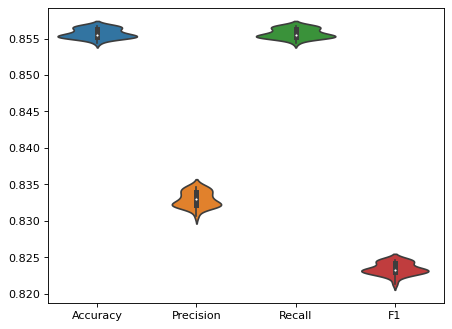

In [ ]:
acc_paths = get_paths("accuracy_list_2023")
prec_paths = get_paths("prec_list_2023")
recall_paths = get_paths("recall_list_2023")
f1_paths = get_paths("f1_list_2023")
auc_paths = get_paths("auc_list_2023")

acc_list = concat_data(acc_paths)
prec_list = concat_data(prec_paths)
recall_list = concat_data(recall_paths)
f1_list = concat_data(f1_paths)
auc_list = concat_data(auc_paths)

df_bootstrap_results = pd.DataFrame({'Accuracy':acc_list, 'AUC':auc_list, 'Precision':prec_list,
                        'Recall':recall_list, 'F1':f1_list})
df_bootstrap_results.to_csv(results_path, index=False)

sns.violinplot(data=df_bootstrap_results[['Accuracy','Precision','Recall','F1']])

<Axes: >

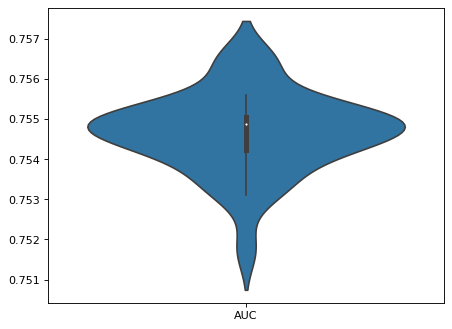

In [ ]:
sns.violinplot(data=df_bootstrap_results[['AUC']])

In [ ]:
df_bootstrap_results.describe().to_csv(summary_stats_path)

{'bodies': [<matplotlib.collections.PolyCollection at 0x78efae3329b0>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x78efae383940>,
 'cmins': <matplotlib.collections.LineCollection at 0x78efae30c310>,
 'cbars': <matplotlib.collections.LineCollection at 0x78efae30c670>}

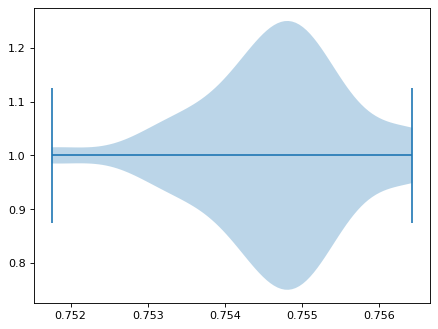

In [ ]:
plt.violinplot(df_bootstrap_results[['AUC']], vert=False)

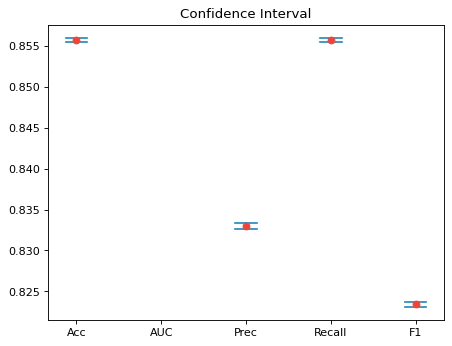

In [ ]:
import matplotlib.pyplot as plt
import statistics
from math import sqrt


def plot_confidence_interval(x, values, z=1.96, color='#2187bb', horizontal_line_width=0.25):
    mean = statistics.mean(values)
    stdev = statistics.stdev(values)
    confidence_interval = z * stdev / sqrt(len(values))

    left = x - horizontal_line_width / 2
    top = mean - confidence_interval
    right = x + horizontal_line_width / 2
    bottom = mean + confidence_interval
    plt.plot([x, x], [top, bottom], color=color)
    plt.plot([left, right], [top, top], color=color)
    plt.plot([left, right], [bottom, bottom], color=color)
    plt.plot(x, mean, 'o', color='#f44336')

    return mean, confidence_interval


plt.xticks([1, 2, 3, 4, 5], ['Acc', 'AUC', 'Prec', 'Recall', 'F1'])
plt.title('Confidence Interval')
plot_confidence_interval(1, df_bootstrap_results['Accuracy'].tolist())
#plot_confidence_interval(2, df_bootstrap_results['AUC'].tolist())
plot_confidence_interval(3, df_bootstrap_results['Precision'].tolist())
plot_confidence_interval(4, df_bootstrap_results['Recall'].tolist())
plot_confidence_interval(5, df_bootstrap_results['F1'].tolist())

plt.show()

In [ ]:
np.round(df_bootstrap_results.quantile([0, 0.025, 0.25, 0.5, 0.75, 0.975, 1]),4).to_csv('summary_stats.csv')